In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 7.1 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 8.8 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 8.4 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12.8 MB 8.6 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 8.7 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 8.6 MB/s eta 0:00:01
     -------------------------------------- - 12.3/12.8 MB 8.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import nltk
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ingdj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [5]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

([<matplotlib.patches.Wedge at 0x2675bd6bf50>,
 [Text(-0.705602603597831, -0.8438749704760549, 'REAL'),
  Text(0.7056023286284262, 0.8438752003905213, 'FAKE')],
 [Text(-0.38487414741699866, -0.4602954384414844, '50.1%'),
  Text(0.38487399743368694, 0.4602955638493752, '49.9%')])

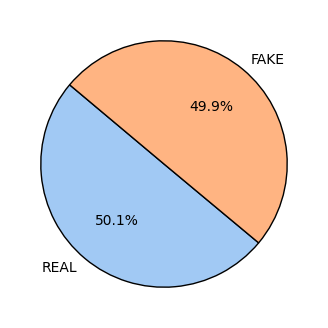

In [6]:
# Contar cuantas noticias reales y fakes hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?
sentimiento_counts = df['sentimiento'].value_counts()

# Para no perder la costumbre y seguir practicando: graficamos.
colors = sns.color_palette('pastel')
plt.figure(figsize=(4, 4))
plt.pie(sentimiento_counts,labels=sentimiento_counts.index,colors=colors,autopct='%1.1f%%',startangle=140,wedgeprops={'edgecolor': 'black'})

No hace falta balancear ya que está muy cerca del 50/50, es decir, ya está balanceado.

In [7]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?
df.shape

(6335, 4)

In [8]:
df.sample(5)

,Unnamed: 0,title,texto,sentimiento
3826,6349,Russia Extends Aleppo Ceasefire Through Friday...,Rebels: Leaving Aleppo 'Completely Out of the ...,FAKE
3006,8953,GERMAN INTERIOR MINISTER demands that Italy se...,GERMAN INTERIOR MINISTER demands that Italy se...,FAKE
4834,6953,Donald Trump Likely to End Aid for Rebels Figh...,Donald Trump Likely to End Aid for Rebels Fig...,FAKE
1934,2825,Does Kerry want an Iran deal too much?,The online comment fits closely with his campa...,REAL
5367,3543,"Why ISIS's reign of fear has worked, and how i...","The Islamic State is brutal, but for a purpose...",REAL


La diferencia que encuentro es que son pocas variables ya que al tratar con cadenas de texto, no se necesitan muchas variables. En este caso, con el titulo y el texto, junto con el texto, podemos ya entrenar un modelo de forma supervisado.

In [9]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

# Definir el número de muestras deseadas por clase
num_muestras_por_clase = 500  # Ajusta este número según tu necesidad

# Separar las clases
df_fake = df[df['sentimiento'] == 'FAKE']
df_real = df[df['sentimiento'] == 'REAL']

# Tomar una muestra aleatoria de cada clase manteniendo el balance
df_fake_sample = df_fake.sample(n=num_muestras_por_clase, random_state=42)
df_real_sample = df_real.sample(n=num_muestras_por_clase, random_state=42)

# Concatenar y mezclar las muestras
df_reducido = pd.concat([df_fake_sample, df_real_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el nuevo balance
df_reducido['sentimiento'].value_counts(normalize=True)

sentimiento
REAL    0.5
FAKE    0.5
Name: proportion, dtype: float64

In [10]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
# Reemplazar los valores de la columna 'sentimiento'
df_reducido['sentimiento'] = df_reducido['sentimiento'].map({'FAKE': 0, 'REAL': 1})

# Verificar los cambios
df_reducido['sentimiento'].value_counts()


sentimiento
1    500
0    500
Name: count, dtype: int64

In [11]:
# Convertir las stopwords en un conjunto
stop_words = set(stopwords.words('english'))

In [12]:
# pasamos al procesamiento de texto:

def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)
"""    
    # Tokenización con nltk
    tokens = nltk.word_tokenize(texto)
    
    # Filtrar stopwords y caracteres no alfabéticos
    tokens_filtrados = [token for token in tokens if token.isalpha() and token not in stop_words]
    
    # Lematización con spaCy
    doc = nlp(" ".join(tokens_filtrados))
    lemas = [token.lemma_ for token in doc]
    
    return " ".join(tokens_filtrados)

"""


'    \n    # Tokenización con nltk\n    tokens = nltk.word_tokenize(texto)\n    \n    # Filtrar stopwords y caracteres no alfabéticos\n    tokens_filtrados = [token for token in tokens if token.isalpha() and token not in stop_words]\n    \n    # Lematización con spaCy\n    doc = nlp(" ".join(tokens_filtrados))\n    lemas = [token.lemma_ for token in doc]\n    \n    return " ".join(tokens_filtrados)\n\n'

In [13]:
# Aplicar preprocesamiento

# Aplicar la función tanto al título como al texto y combinarlos
df_reducido['texto_procesado'] = df_reducido['title'].astype(str) + " " + df_reducido['texto'].astype(str)
df_reducido['texto_procesado'] = df_reducido['texto_procesado'].apply(preprocesar_texto)

# Ver un ejemplo
print(df_reducido[['texto_procesado']].head())

                                     texto_procesado
0  marco rubio strategy utterly baffle something ...
1  mike huckabee netanyahu wage stagnation former...
2  biden backer naysayer fast democrat loyal vice...
3  rick perry drop presidential race washington c...
4  jim rogers time prepare economic financial col...


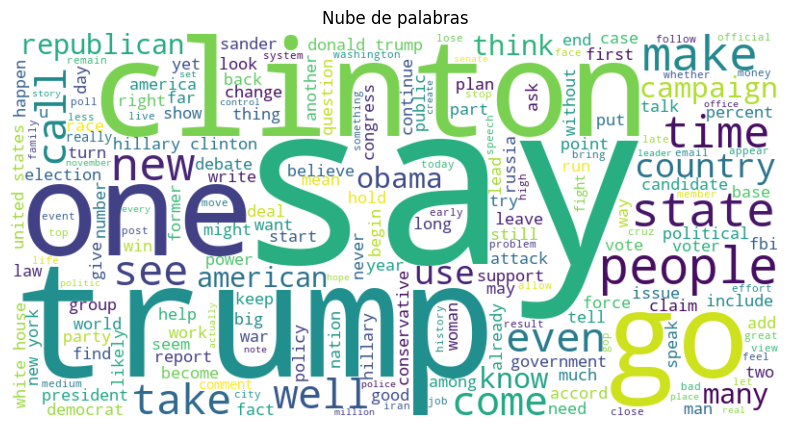

In [14]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_reducido['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

In [ ]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df['texto_procesado'], 1)


print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

In [ ]:

# Separar datos en entrenamiento y prueba


In [ ]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# Entrenar modelo


# Predicciones
y_pred =

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

In [ ]:
y_pred2=pac.predict(tfidf_test)

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))